In [1]:
import pandas as pd
import glob
import os
from sys import path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

path = r"\\wsl.localhost\Ubuntu-22.04\home\ats5662\SchwarzP_VNIT_HarmonicAcousticSimulation\coupledPressureThermoviscousAcoustics\results_hdf5\centerlineSample"
all_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True).sort_values(by=['TimeStep'])
df.drop(columns=['origNodeNums', 'origElementNums', 'origNodeNums', 'vtkValidPointMask', 'Points:0', 'Points:1', 'Points:2'], inplace=True)
df = df[df['acouPressureImag'].notna()]
df

,TimeStep,Time,acouPressureImag,acouPressureReal,arc_length
470044,0,377.0,-1.424186,-81.974090,0.329935
463379,0,377.0,-1.202564,8.902474,0.109989
463378,0,377.0,-1.202295,8.921277,0.109956
463377,0,377.0,-1.202026,8.940079,0.109923
463376,0,377.0,-1.201757,8.958899,0.109890
...,...,...,...,...,...
356701,149,3400.0,-368.343100,-562.066400,0.219978
356700,149,3400.0,-367.958100,-561.384000,0.219945
356699,149,3400.0,-367.573000,-560.701700,0.219912
356698,149,3400.0,-367.188200,-560.019600,0.219879


In [2]:
def myFun(x,Ar,Ai,Br,Bi,k1,k2):
    A = Ar + 1j * Ai
    B = Br + 1j * Bi
    return A*np.exp((-1j*k1-k2)*x) + B*np.exp((1j*k1+k2)*x)

def funcBoth(x,Ar,Ai,Br,Bi,k1,k2):
    p_real = np.real(myFun(x,Ar,Ai,Br,Bi,k1,k2))
    p_imag = np.imag(myFun(x,Ar,Ai,Br,Bi,k1,k2))
    return np.hstack([p_real, p_imag])

In [3]:
K = 1.4261e5
rho = 1.225
c = np.sqrt(K/rho)
store = np.zeros((150, 4))
freqValues = np.linspace(377,3400,150)

for i in range(150):
    dfx = df[df["TimeStep"] == i]
    initialGuess=[0,0,0,0,2*np.pi*freqValues[i]/c,0]
    pBoth = np.hstack([ dfx["acouPressureReal"], dfx["acouPressureImag"] ])
    poptBoth,_ = curve_fit(funcBoth, dfx["arc_length"], pBoth, initialGuess)
    pneg = poptBoth[2] +1j* poptBoth[3]
    pplus = poptBoth[0] +1j* poptBoth[1] 
    xinterface = 0.32967
    lambd = poptBoth[5]
    k1=poptBoth[4]
    cf = 0.875
    r = cf*(pneg/pplus)*np.exp(2*(1j*k1*xinterface+lambd*xinterface))
    Z = (1+r)/(1-r)
    alpha = 1-np.abs(r)**2
    store[i,0] = freqValues[i]
    store[i,1] = alpha
    store[i,2]=np.real(Z)
    store[i,3]=np.imag(Z)

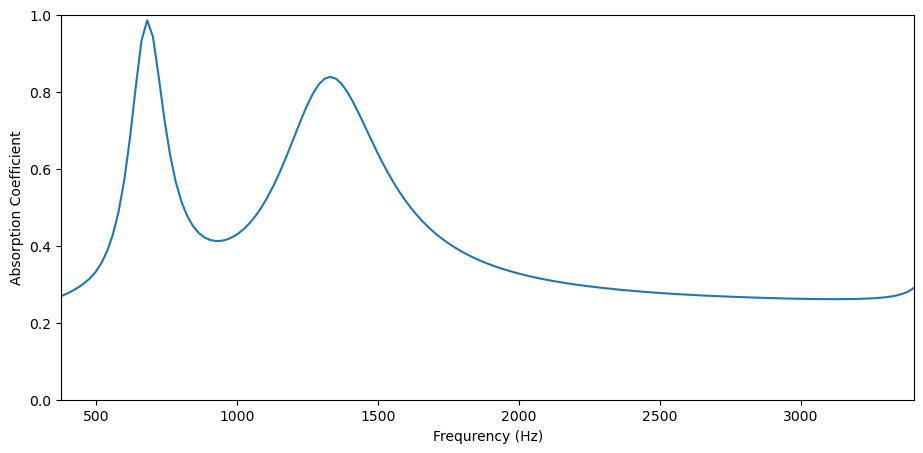

In [4]:
plt.rcParams["figure.figsize"] = (11,5)
fig = plt.figure()
ax = plt.axes()
plt.xlim([377, 3400])
plt.ylim([0, 1])
plt.xlabel("Frequrency (Hz)")
plt.ylabel("Absorption Coefficient")
ax.plot(freqValues,store[:,1])

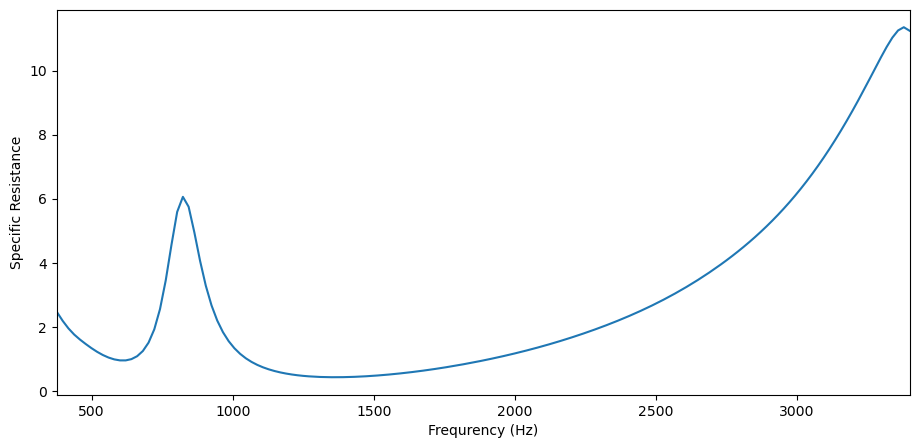

In [5]:
fig1 = plt.figure()
ax1 = plt.axes()
plt.xlim([377, 3400])
plt.xlabel("Frequrency (Hz)")
plt.ylabel("Specific Resistance")
ax1.plot(freqValues,store[:,2])

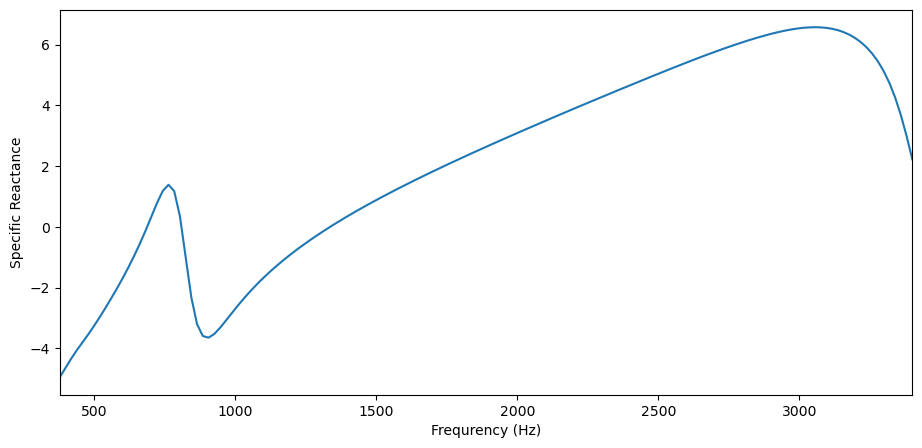

In [6]:
fig2 = plt.figure()
ax2 = plt.axes()
plt.xlim([377, 3400])
plt.xlabel("Frequrency (Hz)")
plt.ylabel("Specific Reactance")
ax2.plot(freqValues,store[:,3])